In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_json(r"../data/df_final_para.json") # paragraphs
df = pd.read_json(r"../data/df_final_document.json") # document

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 187
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Reference                     143 non-null    object
 1   Feedback date                 143 non-null    object
 2   User type                     112 non-null    object
 3   Scope                         4 non-null      object
 4   Organisation name             112 non-null    object
 5   Transparency register number  93 non-null     object
 6   Organisation size             112 non-null    object
 7   label_132                     143 non-null    object
 8   label_134                     143 non-null    object
 9   submit                        143 non-null    int64 
 10  file_name                     73 non-null     object
 11  language                      143 non-null    object
 12  text                          143 non-null    object
 13  text_clean          

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label.132'] = le.fit_transform(df['label_132'])
df['label.134'] = le.fit_transform(df['label_134'])

In [5]:
df['submit'].value_counts()

1    73
0    70
Name: submit, dtype: int64

In [6]:
#only use pdf submissions
df = df[df['submit']==1]

In [ ]:
df.sort_values(by='count', ascending=False)[['Reference', 'count']].head(10)

<AxesSubplot: >

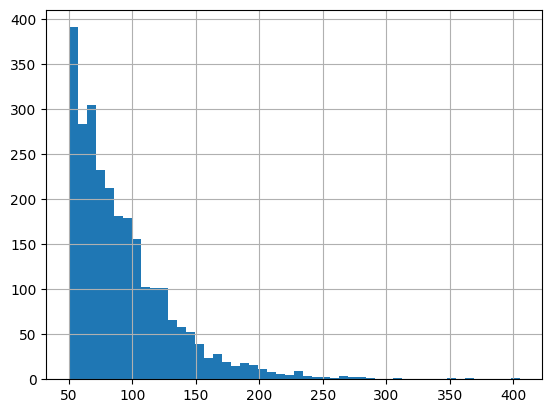

In [168]:
pd.Series(df['count']).hist(bins = 50)

## BERT multi-classification (K=2) using Q132/label.132

References: 

https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/?

https://trishalaneeraj.github.io/2020-04-04/feature-based-approach-with-bert

In [8]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import yaml
import transformers
from transformers import AutoModel, BertTokenizerFast

/Users/janinedevera/opt/miniconda3/envs/tad-project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# specify GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
# split data into train, test, validation sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text_clean'], df['label.132'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label.132'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [11]:
print(len(train_text))
print(len(val_text))
print(len(test_text))

51
11
11


In [12]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased', return_dict=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Import BERT Model and BERT Tokenizer

In [13]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', return_dict=False)

In [14]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

In [15]:
# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

In [16]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Tokenize the Sentences

<AxesSubplot:>

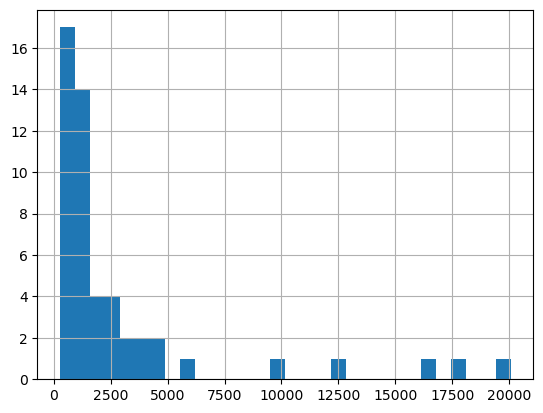

In [17]:
import matplotlib

# get length of all the messages in the train set
seq_len = [len(str(i).split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [18]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/Users/janinedevera/opt/miniconda3/envs/tad-project/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 2

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

Define Model Architecture

In [21]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [22]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [23]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [24]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

/Users/janinedevera/opt/miniconda3/envs/tad-project/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )

class_weights
print("Class Weights:",class_weights)

Class Weights: [1.0625     0.94444444]


In [26]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 20

Fine-Tune BERT

In [27]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 200 batches.
    # if step % 200 == 0 and not step == 0:
    #   print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds


In [28]:
# function for evaluating the model
def evaluate():
  
  #print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 200 batches.
    # if step % 200 == 0 and not step == 0:
      
    #   # Calculate elapsed time in minutes.
    #   #elapsed = format_time(time.time() - t0)
            
    #   # Report progress.
    #   print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [29]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20

Training Loss: 0.700
Validation Loss: 0.699

 Epoch 2 / 20

Training Loss: 0.696
Validation Loss: 0.701

 Epoch 3 / 20

Training Loss: 0.687
Validation Loss: 0.702

 Epoch 4 / 20

Training Loss: 0.701
Validation Loss: 0.701

 Epoch 5 / 20

Training Loss: 0.700
Validation Loss: 0.694

 Epoch 6 / 20

Training Loss: 0.692
Validation Loss: 0.686

 Epoch 7 / 20

Training Loss: 0.686
Validation Loss: 0.687

 Epoch 8 / 20

Training Loss: 0.683
Validation Loss: 0.687

 Epoch 9 / 20

Training Loss: 0.682
Validation Loss: 0.684

 Epoch 10 / 20

Training Loss: 0.676
Validation Loss: 0.685

 Epoch 11 / 20

Training Loss: 0.685
Validation Loss: 0.687

 Epoch 12 / 20

Training Loss: 0.686
Validation Loss: 0.684

 Epoch 13 / 20

Training Loss: 0.690
Validation Loss: 0.682

 Epoch 14 / 20

Training Loss: 0.683
Validation Loss: 0.681

 Epoch 15 / 20

Training Loss: 0.680
Validation Loss: 0.682

 Epoch 16 / 20

Training Loss: 0.681
Validation Loss: 0.680

 Epoch 17 / 20

Training Loss: 0

Make predictions

In [30]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [34]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [35]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.71      0.83      0.77         6

    accuracy                           0.73        11
   macro avg       0.73      0.72      0.72        11
weighted avg       0.73      0.73      0.72        11



In [36]:
df['label.132'].value_counts()

1    39
0    34
Name: label.132, dtype: int64

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 1 to 181
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Reference                     73 non-null     object
 1   Feedback date                 73 non-null     object
 2   User type                     65 non-null     object
 3   Scope                         2 non-null      object
 4   Organisation name             65 non-null     object
 5   Transparency register number  52 non-null     object
 6   Organisation size             65 non-null     object
 7   label_132                     73 non-null     object
 8   label_134                     73 non-null     object
 9   submit                        73 non-null     int64 
 10  file_name                     73 non-null     object
 11  language                      73 non-null     object
 12  text                          73 non-null     object
 13  text_clean           

References for tf-idf word embeddings:

https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html